# Sentiment Analysis of COIVD-19 Vaccine related tweets using Naive Bayes Classification and Keras LSTM Model

## Data pipeline attributes 

### Importing and Downloading Necessary Libraries and Packages

In [65]:
# import EDA libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import data preprocessing libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# import libraries for mechine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences, skipgrams
from tensorflow.keras.utils import to_categorical

In [2]:
# download stopwords and wordnet data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Importing Data

In [3]:
train_dataset = pd.read_csv("Dataset/training_1600000_processed_noemoticon.csv", encoding='latin-1', header=None)
dataset = pd.read_csv("Dataset/vaccine_tweets.csv")

C:\Users\Admin\anaconda3\envs\tfenv\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (1,2,3,4,5,7,8,9,10,11,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Exploratory Data Analysis (EDA)

In [4]:
# display the first five rows of our train dataset
train_dataset.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Here the size of the train dataset is reduced from 1.6milion to 500 thousand words due to system computation limitations. 

In [5]:
# display the first five rows of our dataset
dataset.head()

,username,user_display_name,user_description,user_location,user_verified,user_protected,user_followers_count,user_friends_count,user_statuses_count,user_favourites_count,tweet_content,tweet_language,tweet_retweet_count,tweet_quote_count,tweet_reply_count,tweet_like_count,tweet_id,tweet_url,tweet_date
0,JosephRLeduc,_|®$€¶H 🤪🇨🇦,I'm fully vaccinated and even wear a mask!\nWh...,🇨🇦,False,False,4108.0,4771,21924,22908,Covid-19 denial and inaction from many politic...,en,0.0,0.0,0.0,0,1476898137860018179,https://twitter.com/JosephRLeduc/status/147689...,2021-12-31 12:48:50+00:00
1,MartinesPrisci,prisci martines,NaN,un mundo raro,False,False,2795.0,3538,361761,44778,Most of the World's Vaccines Likely Won't Prev...,en,0.0,0.0,0.0,0,1476898058667450368,https://twitter.com/MartinesPrisci/status/1476...,2021-12-31 12:48:31+00:00
2,SamerItani9,أبو عيسى,NaN,"Dubai, United Arab Emirates",False,False,83.0,326,409,3977,"@ibn_Haile_ Vaccines, contagion, epidemics are...",en,0.0,0.0,0.0,0,1476898049444229121,https://twitter.com/SamerItani9/status/1476898...,2021-12-31 12:48:29+00:00
3,HisLilSecretSHY,Shawnaaaa,IG:_SimplySW SC: Simply_SW,Me; Myselff &&' Shy ;* :),False,False,708.0,159,49095,15864,..Your body is still acceptable to the virus t...,en,0.0,0.0,0.0,0,1476898030695686147,https://twitter.com/HisLilSecretSHY/status/147...,2021-12-31 12:48:24+00:00
4,MattM5001,Steve Howe,Awake but not Woke🇺🇸🇺🇸🇺🇸,"Bowleys Quarters, MD",False,False,1215.0,2741,29427,111327,@DavidBaker2263 And….? They never report the...,en,0.0,0.0,0.0,0,1476898005282394112,https://twitter.com/MattM5001/status/147689800...,2021-12-31 12:48:18+00:00


In [6]:
# obtain a summary of our dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861233 entries, 0 to 861232
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   username               861233 non-null  object 
 1   user_display_name      775541 non-null  object 
 2   user_description       652647 non-null  object 
 3   user_location          485727 non-null  object 
 4   user_verified          757976 non-null  object 
 5   user_protected         757976 non-null  object 
 6   user_followers_count   757976 non-null  float64
 7   user_friends_count     757976 non-null  object 
 8   user_statuses_count    757976 non-null  object 
 9   user_favourites_count  757974 non-null  object 
 10  tweet_content          757974 non-null  object 
 11  tweet_language         732124 non-null  object 
 12  tweet_retweet_count    732124 non-null  float64
 13  tweet_quote_count      732124 non-null  float64
 14  tweet_reply_count      732124 non-nu

In [7]:
# check for null values
dataset.isna().sum()

username                      0
user_display_name         85692
user_description         208586
user_location            375506
user_verified            103257
user_protected           103257
user_followers_count     103257
user_friends_count       103257
user_statuses_count      103257
user_favourites_count    103259
tweet_content            103259
tweet_language           129109
tweet_retweet_count      129109
tweet_quote_count        129109
tweet_reply_count        129109
tweet_like_count         129109
tweet_id                 129109
tweet_url                129125
tweet_date               129125
dtype: int64

In [8]:
# drop rows with null values
dataset.dropna(inplace=True)

In [9]:
# confirm all rows with null values has been dropped
dataset.isna().sum()

username                 0
user_display_name        0
user_description         0
user_location            0
user_verified            0
user_protected           0
user_followers_count     0
user_friends_count       0
user_statuses_count      0
user_favourites_count    0
tweet_content            0
tweet_language           0
tweet_retweet_count      0
tweet_quote_count        0
tweet_reply_count        0
tweet_like_count         0
tweet_id                 0
tweet_url                0
tweet_date               0
dtype: int64

In [10]:
# obtain a summary of our dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 430102 entries, 0 to 861232
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   username               430102 non-null  object 
 1   user_display_name      430102 non-null  object 
 2   user_description       430102 non-null  object 
 3   user_location          430102 non-null  object 
 4   user_verified          430102 non-null  object 
 5   user_protected         430102 non-null  object 
 6   user_followers_count   430102 non-null  float64
 7   user_friends_count     430102 non-null  object 
 8   user_statuses_count    430102 non-null  object 
 9   user_favourites_count  430102 non-null  object 
 10  tweet_content          430102 non-null  object 
 11  tweet_language         430102 non-null  object 
 12  tweet_retweet_count    430102 non-null  float64
 13  tweet_quote_count      430102 non-null  float64
 14  tweet_reply_count      430102 non-nu

#### Tweets by Location

In [11]:
# group the DataFrame by column 'user_location', and count the values in column 'user_location'
counts = dataset.groupby('user_location')['user_location'].size()

# convert the counts to a DataFrame and reset the index
counts_df = counts.reset_index(name='count')

counts_df.nlargest(50, 'count')

,user_location,count
64392,United States,10452
63726,USA,5430
12367,Canada,4198
64332,United Kingdom,3978
34674,"London, England",3858
34371,London,3451
66471,"Washington, DC",3070
6841,Australia,2862
35150,"Los Angeles, CA",2816
12132,"California, USA",2744


In this code, we count the number of occurrences of each unique value in the 'user_location' column and then display the top 50 locations with the highest counts. This is useful for understanding where the majority of users are located and how the data is distributed across locations. 

We ran this code multiple times to see locations that could be grouped together as implemented in the cell below.

In [12]:
# Use numpy arrays to create location groupings
united_kingdom = np.array(['United Kingdom', 'London', 'England', 'Scotland', 'UK', 'Glasgow', 'Edinburgh', 'Liverpool',
                          'Bristol', 'Leeds', 'West Midlands', 'Essex', 'Sheffield'
                          ])
australia = np.array(['Australia', 'Melbourne', 'Sydney', 'New South Wales', 'Perth', 'Western Australia', 'Brisbane', 
                      'Queensland', 'Adelaide', 'South Australia'
                     ])
canada = np.array(['Canada', 'Toronto', 'Ontario', 'Vancouver', 'British Columbia', 'Edmonton', 'Alberta', 'Montréal', 
                   'Québec'
                  ])
south_africa = np.array(['South Africa', 'Johannesburg'])
india = np.array(['India', 'New Delhi', 'Mumbai'])
europe = np.array(['Ireland', 'Dublin City', 'Dublin', 'Europe', 'Geneva', 'Switzerland', 'The Netherlands', 'Sweden',
                  'Italy', 'Amsterdam', 'Nederland', 'Plague Island'
                  ])
nigeria = np.array(['Nigeria', 'Lagos', 'Abuja'])
new_zealand = np.array(['New Zealand', 'Auckland', 'Aotearoa'])
united_states = np.array(['United States', 'USA', 'Washington', 'DC', 'Los Angeles', 'CA', 'California', 
                        'New York', 'NY', 'Chicago', 'IL', 'Florida', 'Texas', 'Boston', 'MA', 'Seattle', 'WA',
                        'Atlanta', 'GA', 'Houston', 'TX', 'Philadelphia', 'PA', 'New Jersey', 'Ohio', 'Brooklyn',
                        'Michigan', 'Austin', 'North Carolina', 'San Diego', 'Pennsylvania', 'Dallas', 'NYC', 
                        'San Francisco', 'MD', 'Miami', 'FL', 'Denver', 'CO', 'Portland', 'OR', 'Phoenix', 'AZ', 
                        'Minneapolis', 'MN', 'Charlotte', 'NC', 'Indianapolis', 'IN', 'Cleveland', 'OH', 'Colorado',
                        'Arizona', 'Detroit', 'MI', 'US', 'St Louis', 'MO', 'Kansas City', 'Salt Lake City', 'UT', 'Utah',
                        'Memphis', 'TN', 'Albuquerque', 'NM', 'Tennessee', 'Boise', 'ID', 'Honolulu', 'HI', 'New Haven', 
                        'CT', 'Tulsa', 'OK', "U.S.A.", 'New Hampshire', 'Baton Rouge', 'LA', 'Charleston', 'SC', 'Kansas',
                        'The United States of America', 'United States of America'
                         ])
rest_of_world_filter = np.array(['United Kingdom', 'Australia', 'Canada', 'South Africa', 'India', 
                                 'Europe', 'Nigeria', 'New Zealand'
                                ])

In [13]:
# define a function to check for United Kingdom locations
def is_uk_location(location):
    for word in united_kingdom:
        if word.lower() in location.lower():
            return True
    return False

# define a function to check for Australia locations
def is_australia_location(location):
    for word in australia:
        if word.lower() in location.lower():
            return True
    return False

# define a function to check for Canada locations
def is_canada_location(location):
    for word in canada:
        if word.lower() in location.lower():
            return True
    return False

# define a function to check for South Africa locations
def is_sa_location(location):
    for word in south_africa:
        if word.lower() in location.lower():
            return True
    return False

# define a function to check for India locations
def is_india_location(location):
    for word in india:
        if word.lower() in location.lower():
            return True
    return False

# define a function to check for Europe locations
def is_europe_location(location):
    for word in europe:
        if word.lower() in location.lower():
            return True
    return False

# define a function to check for Nigeria locations
def is_nigeria_location(location):
    for word in nigeria:
        if word.lower() in location.lower():
            return True
    return False

# define a function to check for New Zealand locations
def is_nz_location(location):
    for word in new_zealand:
        if word.lower() in location.lower():
            return True
    return False

# define a function to check for United States locations
def is_us_location(location):
    for word in united_states:
        if word.lower() in location.lower():
            return True
    return False

# define a function to check for locations not in any of the difined location categories
def rest_of_world(location):
    for word in rest_of_world_filter:
        if word.lower() in location.lower():
            return True
    return False

In [14]:
# create column "new_locations" with data from "user_location" column
dataset['new_locations'] = dataset['user_location']

In [15]:
# apply the location checking functions to the "new_location" column
dataset['new_locations'] = dataset['new_locations'].apply(lambda x: 'United Kingdom' if is_uk_location(x) else x)
dataset['new_locations'] = dataset['new_locations'].apply(lambda x: 'Australia' if is_australia_location(x) else x)
dataset['new_locations'] = dataset['new_locations'].apply(lambda x: 'Canada' if is_canada_location(x) else x)
dataset['new_locations'] = dataset['new_locations'].apply(lambda x: 'South Africa' if is_sa_location(x) else x)
dataset['new_locations'] = dataset['new_locations'].apply(lambda x: 'India' if is_india_location(x) else x)
dataset['new_locations'] = dataset['new_locations'].apply(lambda x: 'Europe' if is_europe_location(x) else x)
dataset['new_locations'] = dataset['new_locations'].apply(lambda x: 'Nigeria' if is_nigeria_location(x) else x)
dataset['new_locations'] = dataset['new_locations'].apply(lambda x: 'New Zealand' if is_nz_location(x) else x)
dataset['new_locations'] = dataset['new_locations'].apply(lambda x: x if rest_of_world(x)
                                                          else ("United States" if is_us_location(x)
                                                          else "Rest of the World")
                                                         )

After creating numpy arrays for each category, we defined functions that take user locations and checks if any of the words in our categorical arrays appear in the location. The function returns True if any of the words appear in the location, and False otherwise. 

We then use the apply() method to apply the individual functions to each row in the "new_locations" column.

In [16]:
# view the updated dataframe
dataset.head()

,username,user_display_name,user_description,user_location,user_verified,user_protected,user_followers_count,user_friends_count,user_statuses_count,user_favourites_count,tweet_content,tweet_language,tweet_retweet_count,tweet_quote_count,tweet_reply_count,tweet_like_count,tweet_id,tweet_url,tweet_date,new_locations
0,JosephRLeduc,_|®$€¶H 🤪🇨🇦,I'm fully vaccinated and even wear a mask!\nWh...,🇨🇦,False,False,4108.0,4771,21924,22908,Covid-19 denial and inaction from many politic...,en,0.0,0.0,0.0,0,1476898137860018179,https://twitter.com/JosephRLeduc/status/147689...,2021-12-31 12:48:50+00:00,Rest of the World
3,HisLilSecretSHY,Shawnaaaa,IG:_SimplySW SC: Simply_SW,Me; Myselff &&' Shy ;* :),False,False,708.0,159,49095,15864,..Your body is still acceptable to the virus t...,en,0.0,0.0,0.0,0,1476898030695686147,https://twitter.com/HisLilSecretSHY/status/147...,2021-12-31 12:48:24+00:00,Rest of the World
4,MattM5001,Steve Howe,Awake but not Woke🇺🇸🇺🇸🇺🇸,"Bowleys Quarters, MD",False,False,1215.0,2741,29427,111327,@DavidBaker2263 And….? They never report the...,en,0.0,0.0,0.0,0,1476898005282394112,https://twitter.com/MattM5001/status/147689800...,2021-12-31 12:48:18+00:00,United States
6,SarcasmoDeMiami,**Sarcasio del Navidad**,"Priv, white cis-♂️atty. Goals: providing educa...","Miami, Florida, USA",False,False,338.0,358,22769,27759,@AlanVRK @Mike_Grieco A few months back I help...,en,0.0,0.0,0.0,0,1476897881630162944,https://twitter.com/SarcasmoDeMiami/status/147...,2021-12-31 12:47:49+00:00,United States
8,Bari1951,Fred Barendsma,In de eerste plaats hou ik van Jesjoea. Hij is...,"Katwijk ZH, The Netherlands",False,False,1130.0,807,129120,227151,SHOCKING: Compilation of Nurse Whistleblowers ...,en,0.0,0.0,0.0,0,1476897810582847496,https://twitter.com/Bari1951/status/1476897810...,2021-12-31 12:47:32+00:00,Europe


In [17]:
# group the DataFrame by column 'new_locations', and count the values in column 'new_locations'
counts =dataset.groupby('new_locations')['new_locations'].size()

# convert the counts to a DataFrame and reset the index
counts_df = counts.reset_index(name='count')

In [18]:
counts_df

,new_locations,count
0,Australia,13818
1,Canada,24029
2,Europe,9563
3,India,9054
4,New Zealand,3635
5,Nigeria,858
6,Rest of the World,47918
7,South Africa,5315
8,United Kingdom,48998
9,United States,266914


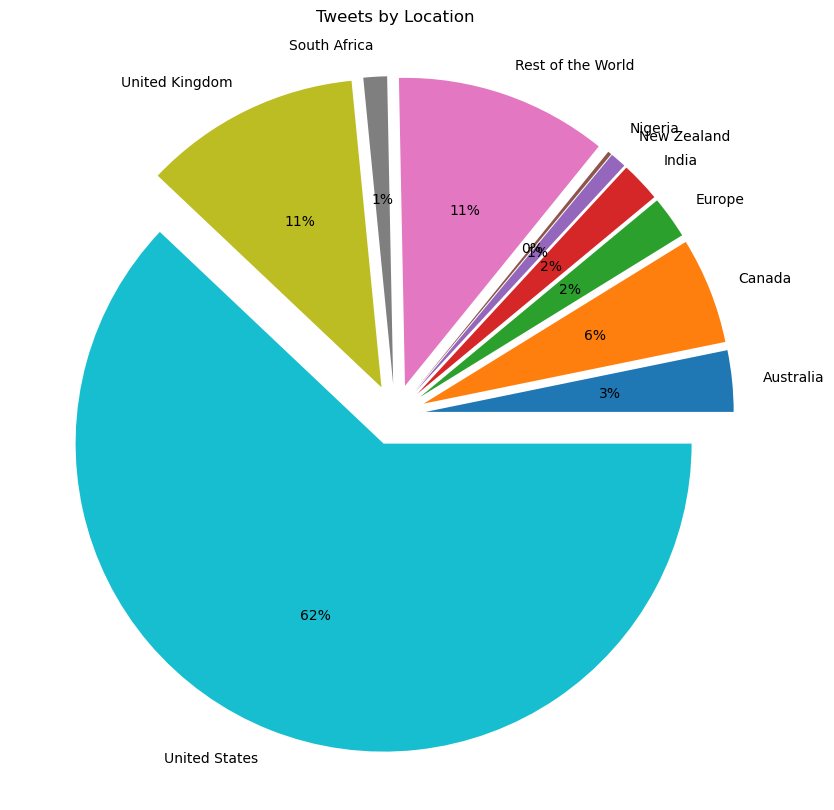

In [19]:
# visualising tweets by location
# set the size of the figure using plt.figure()
plt.figure(figsize=(10, 10))

# create the bar plot
plt.pie(counts_df['count'], labels=counts_df['new_locations'], 
        explode = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], autopct='%.0f%%'
       )
plt.title('Tweets by Location')

# show the plot
plt.show()

#### Tweets by Date (Month)

In [20]:
# create new column with date by month
dataset['Month_Year'] = [i[:7] for i in dataset['tweet_date']]

In [21]:
# group the DataFrame by column 'Month_Year', and count the values in column 'Month_Year'
counts = dataset.groupby('Month_Year')['Month_Year'].size()

# convert the counts to a DataFrame and reset the index
counts_df = counts.reset_index(name='count')

In [22]:
counts_df

,Month_Year,count
0,2021-10,23801
1,2021-11,180093
2,2021-12,226208


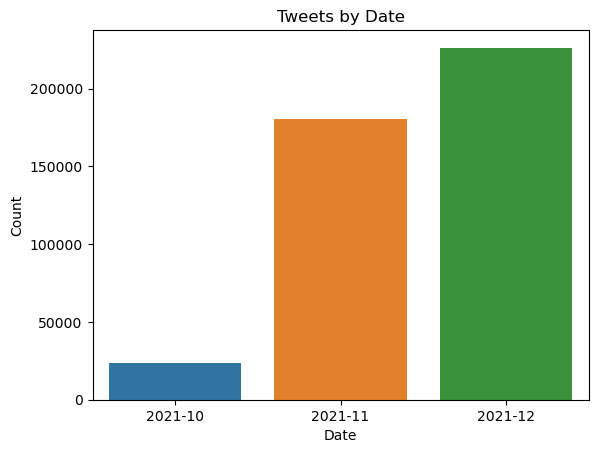

In [23]:
# create the bar plot
sns.barplot(x='Month_Year', y='count', data=counts_df)
plt.title('Tweets by Date')
plt.xlabel('Date')
plt.ylabel('Count')

# show the plot
plt.show()

#### Tweets by Language

In [24]:
# check number of tweet languages 
dataset.groupby('tweet_language')['tweet_language'].size()

tweet_language
en     430085
et          1
fr          2
pt          1
tl         12
und         1
Name: tweet_language, dtype: int64

In [25]:
# create new language column
dataset['tweet_language_new'] = ['English' if i=='en' else 'other' for i in dataset['tweet_language']]

In [26]:
# group the DataFrame by column 'tweet_language', and count the values in column 'tweet_language'
counts = dataset.groupby('tweet_language_new')['tweet_language_new'].size()

# convert the counts to a DataFrame and reset the index
counts_df = counts.reset_index(name='count')

In [27]:
counts_df

,tweet_language_new,count
0,English,430085
1,other,17


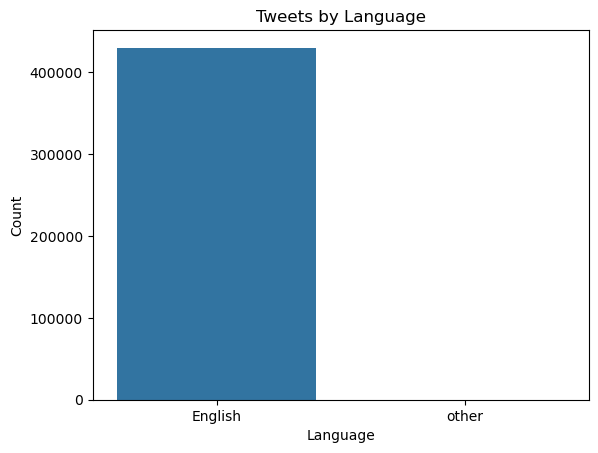

In [28]:
# create the bar plot
sns.barplot(x='tweet_language_new', y='count', data=counts_df)
plt.title('Tweets by Language')
plt.xlabel('Language')
plt.ylabel('Count')

# show the plot
plt.show()

#### Tweets by User Verification Status

In [29]:
# check number of verified twitter users
dataset.groupby('user_verified')['user_verified'].size()

user_verified
False    215182
True      18509
False    182112
True      14299
Name: user_verified, dtype: int64

In [30]:
# confirm the number of unique values in column
dataset['user_verified'].unique()

array([False, True, 'False', 'True'], dtype=object)

We see that there are only to unique values in this column. However, there are also two data types in this column, that is, string and boolean. Hence, we will create a new column to merge these values in one data type, that is, the new column with comprise only string. This is implemented in the cell below.

In [31]:
# create new column for verified twitter users
dataset['user_verified_new'] = ['True' if i=='True' else 'True' if i==True else 'False' for i in dataset['user_verified']]

In [32]:
# group the DataFrame by column 'user_verified', and count the values in column 'user_verified'
counts = dataset.groupby('user_verified_new')['user_verified_new'].size()

# convert the counts to a DataFrame and reset the index
counts_df = counts.reset_index(name='count')

In [33]:
counts_df

,user_verified_new,count
0,False,397294
1,True,32808


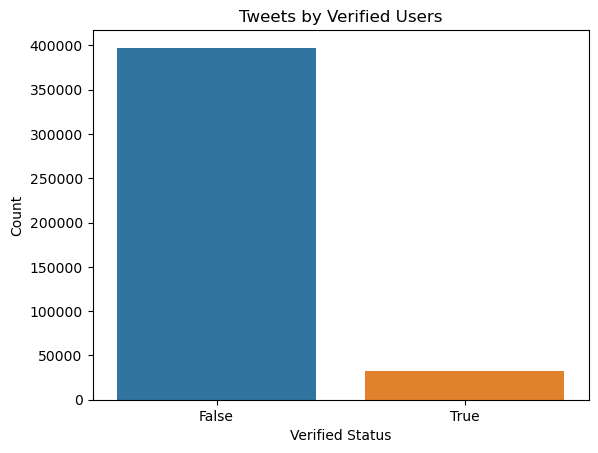

In [34]:
# create the bar plot
sns.barplot(x='user_verified_new', y='count', data=counts_df)
plt.title('Tweets by Verified Users')
plt.xlabel('Verified Status')
plt.ylabel('Count')

# show the plot
plt.show()

## Design and development (methodology)

### Data Cleaning and Preprocessing

In [35]:
# change the column names and display the first five rows of our train dataset
train_dataset = train_dataset.rename(columns={0: 'target', 1: 'ids', 2: 'date', 3: 'flag', 4: 'user', 5: 'text'})
train_dataset.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [36]:
train_dataset = train_dataset.drop(columns=['ids', 'date', 'flag', 'user'])
train_dataset.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [37]:
# reducing the size of the train dataset to reduce computational cost
train_dataset = train_dataset.sample(n=200000, random_state=1)
train_dataset['target'].value_counts()

4    100121
0     99879
Name: target, dtype: int64

In [38]:
# changing the target value 4 to 1
train_dataset['target'] = train_dataset['target'].apply(lambda x: 1 if x == 4 else x)

In [39]:
train_dataset['target'].value_counts()

1    100121
0     99879
Name: target, dtype: int64

In [40]:
# define function to clean and preprocess tweet text data
def clean_tweet(tweet):
    
    tweet = re.sub(r"http\S+", "", tweet) # remove URLs
    tweet = re.sub(r"@\w+", "", tweet) # remove mentions
    tweet = re.sub(r"[^\w\s]", "", tweet) # remove punctuations
    tweet = re.sub(r"\w*\d\w*","", tweet) # removing numerical data
    tweet = re.sub(r"(.)\\1{2,}", "\\1", tweet) # removing duplicate characters
    tweet = re.sub(r"[^\x00-\x7F]+", "", tweet) # removing non ASCII characters 
    tweet = re.sub(r" +", " ",tweet) # removing multiple whitespaces
    tweet = tweet.lower() # make text lowercase

    # tokenize tweets using word_tokenize
    tokens = word_tokenize(tweet)

    # remove stopwords
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # lemmatize tweets using WordNetLemmatizer
    lemmatizer = WordNetLemmatizer() # initiating a Lemmatization instance
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back together into a string
    cleaned_tweet = " ".join(lemmatized_tokens)

    return cleaned_tweet

In [41]:
# select only necessary columns
dataset = dataset[['tweet_date', 'user_location', 'user_verified', 'tweet_content']]

In [42]:
# use the apply() method to clean and preprocess tweet text in the tweet_content column
dataset['clean_tweets'] = dataset['tweet_content'].apply(clean_tweet)
dataset.head()

,tweet_date,user_location,user_verified,tweet_content,clean_tweets
0,2021-12-31 12:48:50+00:00,🇨🇦,False,Covid-19 denial and inaction from many politic...,denial inaction many political world leader cr...
3,2021-12-31 12:48:24+00:00,Me; Myselff &&' Shy ;* :),False,..Your body is still acceptable to the virus t...,body still acceptable virus vaccine protects
4,2021-12-31 12:48:18+00:00,"Bowleys Quarters, MD",False,@DavidBaker2263 And….? They never report the...,never report many droppeddead vaccine got vaccine
6,2021-12-31 12:47:49+00:00,"Miami, Florida, USA",False,@AlanVRK @Mike_Grieco A few months back I help...,month back helped international friend get fam...
8,2021-12-31 12:47:32+00:00,"Katwijk ZH, The Netherlands",False,SHOCKING: Compilation of Nurse Whistleblowers ...,shocking compilation nurse whistleblower aroun...


### Visualising the most common words in the Dataset Using Cloud Words

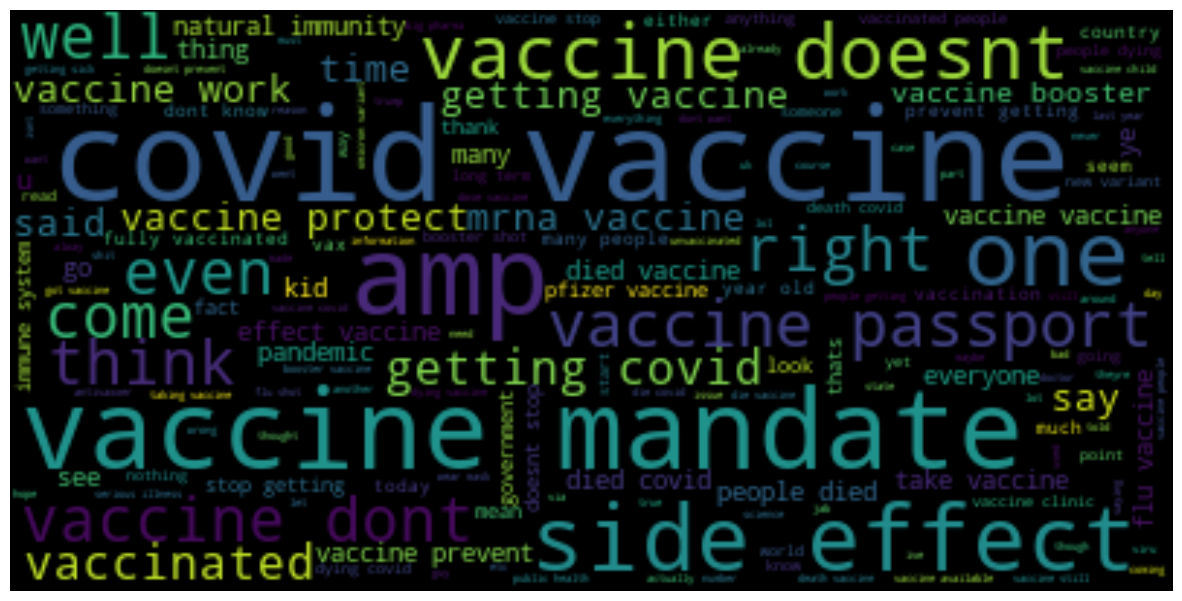

In [43]:
from wordcloud import WordCloud

# Create and generate a word cloud image:
text = ' '.join(dataset['clean_tweets'])
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.figure(figsize = (15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [44]:
# use the apply() method to clean and preprocess tweet text in the our train dataset
train_dataset['clean_tweets'] = train_dataset['text'].apply(clean_tweet)
train_dataset.head()

,target,text,clean_tweets
514293,0,i miss nikki nu nu already shes always there ...,miss nikki nu nu already shes always needed th...
142282,0,So I had a dream last night. I remember a sig...,dream last night remember sign clearly told ge...
403727,0,@girlyghost ohh poor sickly you (((hugs)) ho...,ohh poor sickly hug hope feel little better soon
649503,0,it is raining again,raining
610789,0,@MissKeriBaby wish I was in LA right now,wish la right


## Feature Engineering

In [45]:
X = train_dataset['clean_tweets']
y = train_dataset['target'].values

In [46]:
# Spliting X and y data into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 1, stratify=y)

## Model Implementation using Naive Bayes Classifier and Keras LTSM

### Naive Bayes Classifier

In [48]:
# Create a TfidfVectorizer to convert the text into a matrix of TF-IDF features
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a Multinomial Naive Bayes classifier on the training set
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

# Make predictions on the testing set
y_pred = clf.predict(X_test_tfidf)

Specificity: 0.783189827793352

Sensitivity: 0.7341190571314423



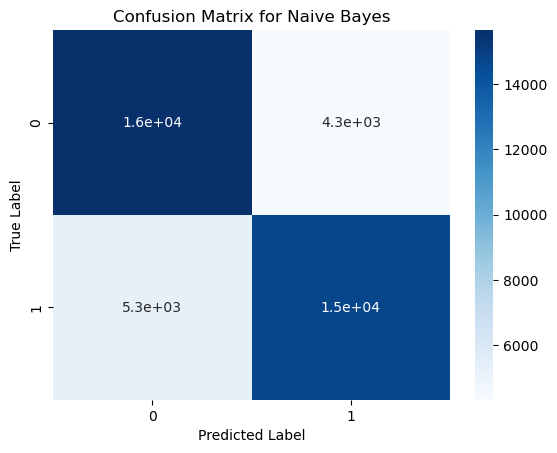

In [49]:
# Create the confusion matrix
conmat = confusion_matrix(y_test, y_pred)

specificity = conmat[0,0]/(conmat[0,0]+conmat[0,1])
sensitivity = conmat[1,1]/(conmat[1,1]+conmat[1,0])

# Calculate the specificity and sensitivity performance metrics from the confusion matrix
print(f'Specificity: {specificity}\n')
print(f'Sensitivity: {sensitivity}\n')

# plot the confusion matrix
sns.heatmap(conmat, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for Naive Bayes')
plt.show()

### Word Embedding

In [62]:
# transform array of text into 2D numeric arrays
max_words = 5000
max_len = 200

# Tokenize the dataset
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)
sequences_2 = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to ensure they are all the same length
X_train = pad_sequences(sequences, maxlen=max_len)
X_test = pad_sequences(sequences_2, maxlen=max_len)

In [63]:
print(X_train)

[[   0    0    0 ...   10    1   57]
 [   0    0    0 ... 1018  505  225]
 [   0    0    0 ...    0    0  247]
 ...
 [   0    0    0 ...    0    0  104]
 [   0    0    0 ...    0    0  355]
 [   0    0    0 ... 1484  271 3417]]


### LSTM layers

In [64]:
# Define the model architecture
model = keras.Sequential()
model.add(Embedding(max_words, 40)) #The embedding layer
model.add(LSTM(64,dropout=0.5)) #Our LSTM layer
model.add(Dense(2,activation='softmax'))

In [65]:
# compile model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
# train model
history = model.fit(X_train, to_categorical(y_train), epochs=10, validation_data=(X_test, to_categorical(y_test)), batch_size=200)

Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 467s 3ms/sample - loss: 0.5222 - acc: 0.7423 - val_loss: 0.4883 - val_acc: 0.7697
Epoch 2/10
160000/160000 [==============================] - 412s 3ms/sample - loss: 0.4778 - acc: 0.7748 - val_loss: 0.4791 - val_acc: 0.7722
Epoch 3/10
160000/160000 [==============================] - 449s 3ms/sample - loss: 0.4685 - acc: 0.7789 - val_loss: 0.4757 - val_acc: 0.7744
Epoch 4/10
160000/160000 [==============================] - 487s 3ms/sample - loss: 0.4631 - acc: 0.7814 - val_loss: 0.4763 - val_acc: 0.7754
Epoch 5/10
160000/160000 [==============================] - 369s 2ms/sample - loss: 0.4624 - acc: 0.7819 - val_loss: 0.4802 - val_acc: 0.7725
Epoch 6/10
160000/160000 [==============================] - 495s 3ms/sample - loss: 0.4553 - acc: 0.7849 - val_loss: 0.4724 - val_acc: 0.7759
Epoch 7/10
160000/160000 [==============================] - 455s 3ms/sample - loss: 0.4512 - acc:

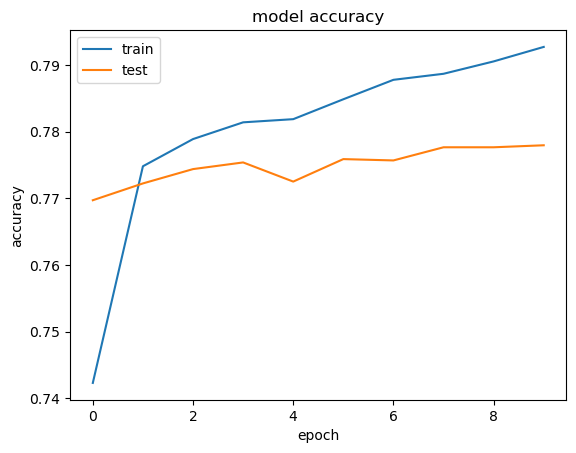

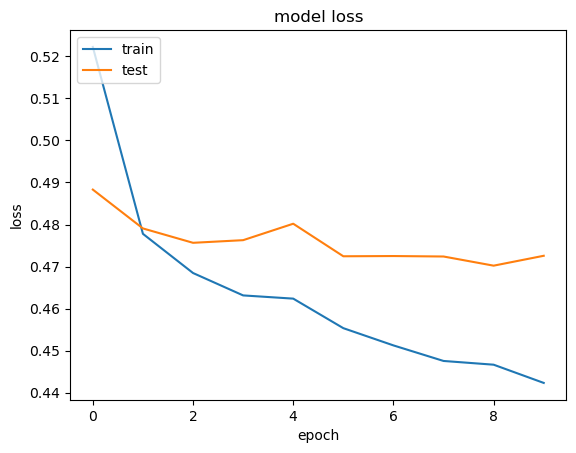

In [67]:
l

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Specificity: 0.7556134723336007

Sensitivity: 0.8002294493216281



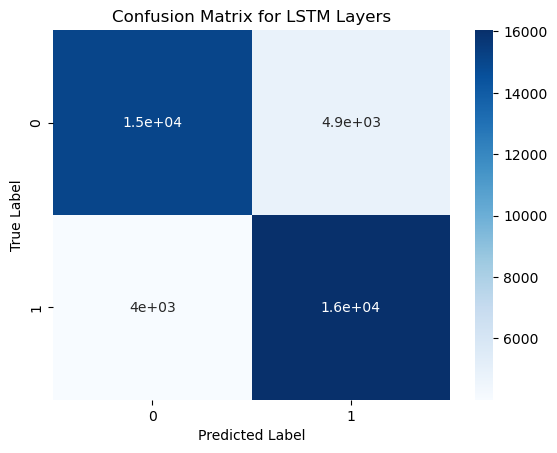

In [68]:
y_pred = model.predict(X_test)
y_pred_binary = np.around(y_pred, decimals=0).argmax(axis=1) # Convert probabilities to binary predictions

# Create the confusion matrix
conmat = confusion_matrix(y_test, y_pred_binary)

specificity = conmat[0,0]/(conmat[0,0]+conmat[0,1])
sensitivity = conmat[1,1]/(conmat[1,1]+conmat[1,0])

# Calculate the specificity and sensitivity performance metrics from the confusion matrix
print(f'Specificity: {specificity}\n')
print(f'Sensitivity: {sensitivity}\n')

# plot the confusion matrix
sns.heatmap(conmat, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for LSTM Layers')
plt.show()

## Obtain Sentiment of COVID-19 Tweets using Best Performing Model

In [70]:
# # Create a TfidfVectorizer to convert the text into a matrix of TF-IDF features
# vectorizer = TfidfVectorizer()
# X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(dataset['clean_tweets'])

# # Train a Multinomial Naive Bayes classifier on the training set
# clf = MultinomialNB()
# clf.fit(X_train_tfidf, y_train)

# Make predictions on the testing set
y_pred = clf.predict(X_test_tfidf)

In [71]:
dataset['tweet_sentiment'] = y_pred

In [72]:
dataset.head()

,tweet_date,user_location,user_verified,tweet_content,clean_tweets,tweet_sentiment
0,2021-12-31 12:48:50+00:00,🇨🇦,False,Covid-19 denial and inaction from many politic...,denial inaction many political world leader cr...,1
3,2021-12-31 12:48:24+00:00,Me; Myselff &&' Shy ;* :),False,..Your body is still acceptable to the virus t...,body still acceptable virus vaccine protects,0
4,2021-12-31 12:48:18+00:00,"Bowleys Quarters, MD",False,@DavidBaker2263 And….? They never report the...,never report many droppeddead vaccine got vaccine,0
6,2021-12-31 12:47:49+00:00,"Miami, Florida, USA",False,@AlanVRK @Mike_Grieco A few months back I help...,month back helped international friend get fam...,1
8,2021-12-31 12:47:32+00:00,"Katwijk ZH, The Netherlands",False,SHOCKING: Compilation of Nurse Whistleblowers ...,shocking compilation nurse whistleblower aroun...,1


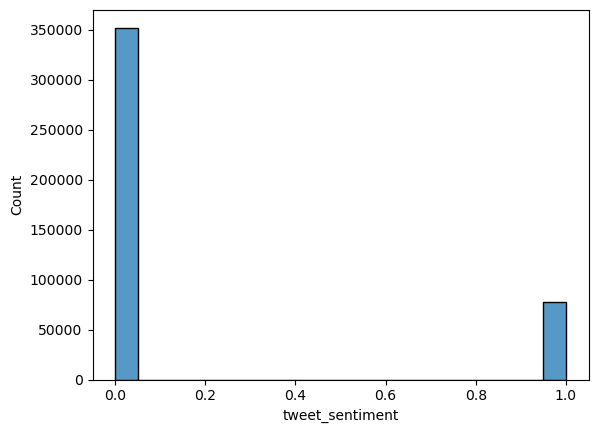

In [76]:
# distribution of tweet sentiments
sns.histplot(data=dataset['tweet_sentiment'], stat='count')
plt.show()